In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from scipy.stats import ttest_1samp, pearsonr
from sklearn.metrics import r2_score
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'Functional_Fusion')
sys.path.append(dname)
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

In [8]:
dname = join(dir_git,'PcmPy')
sys.path.append(dname)
import PcmPy as pcm

In [9]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [10]:
list_sn = su.get_list_sn()

---

In [11]:
h = 'L'
list_roi = simage.get_list_roi()

---

In [12]:
glm = 1
dir_glm = ssingle.get_dir_glmsingle(glm)
dir_glm

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1'

---

In [13]:
subj = 'S01'

In [14]:
mask = simage.load_mask(subj=subj)
mask.shape

(116, 116, 57)

---

reference: [https://glmsingle.readthedocs.io/en/latest/matlab.html](https://glmsingle.readthedocs.io/en/latest/matlab.html)

## Model

### Type A (On-Off Model)

A = simple ONOFF model

In [15]:
model = ssingle.load_model(subj,glm,type='A')
model.keys()

<KeysViewHDF5 ['#refs#', 'R2', 'R2run', 'meanvol', 'modelmd', 'residstd', 'residstdlowpass']>

`GLMsingle` returns model results in the output variable *results*. These results are saved to disk in files called ‘TYPEA…’, ‘TYPEB…’, and so on. There are various outputs for each of the four model types:

- `modelmd` is either:
    1. the HRF (time x 1) and ON-OFF beta weights (X x Y x Z)
    2. the full set of single-trial beta weights (X x Y x Z x TRIALS)

- `R2` is model accuracy expressed in terms of R^2 (percentage, 0-100).

- `R2run` is R2 separated by run

- `meanvol` is the mean of all volumes

### Type B (FIT HRF)

B = single-trial estimates using a tailored HRF for every voxel

In [16]:
model = ssingle.load_model(subj,glm,type='B')
model.keys()

<KeysViewHDF5 ['FitHRFR2', 'FitHRFR2run', 'HRFindex', 'HRFindexrun', 'R2', 'R2run', 'meanvol', 'modelmd']>

- `FitHRFR2` is the R2 for each of the different HRFs in the library

- `FitHRFR2run` is separated by run

- `HRFindex` is the 1-index of the best HRF

- `HRFindexrun` is HRFindex separated by run

### Type C (FIT HRF w/ GLM denoise)

C = like B but with GLMdenoise regressors added into the model

In [17]:
model = ssingle.load_model(subj,glm,type='C')
model.keys()

<KeysViewHDF5 ['#refs#', 'HRFindex', 'HRFindexrun', 'R2', 'R2run', 'glmbadness', 'meanvol', 'modelmd', 'noisepool', 'pcnum', 'pcregressors', 'pcvoxels', 'xvaltrend']>

- `noisepool` indicates voxels selected for the noise pool

- `pcregressors` indicates the full set of candidate GLMdenoise regressors that were found

- `glmbadness` is the cross-validation results for GLMdenoise

- `pcvoxels` is the set of voxels used to summarize GLMdenoise cross-validation results

- `xvaltrend` is the summary GLMdenoise cross-validation result on which pcnum selection is done

- `pcnum` is the number of PCs that were selected for the final model

### Type D (FIT HRF w/ GLM denoise & Ridge Regression)

D = like C but with ridge regression regularization (tailored to each voxel)

In [18]:
model = ssingle.load_model(subj,glm,type='D')
model.keys()

<KeysViewHDF5 ['#refs#', 'FRACvalue', 'HRFindex', 'HRFindexrun', 'R2', 'R2run', 'glmbadness', 'meanvol', 'modelmd', 'noisepool', 'pcnum', 'pcregressors', 'pcvoxels', 'rrbadness', 'scaleoffset', 'xvaltrend']>

- `FRACvalue` is the fractional ridge regression regularization level chosen for each voxel

- `rrbadness` is the cross-validation results for the ridge regression

- `scaleoffset` is the scale and offset applied to RR estimates to best match the unregularized result

Note that not all outputs exist for every model type.

---

## Design Matrix

In [19]:
designinfo = ssingle.load_designinfo(subj, glm)
designinfo.keys()

<KeysViewHDF5 ['#refs#', 'condcounts', 'condinruns', 'design', 'designSINGLE', 'endbuffers', 'numtrialrun', 'opt', 'stimdur', 'stimorder', 'tr']>

`GLMsingle` also returns design-related results in the output variable *resultsdesign*. These results are saved to disk to a file called ‘DESIGNINFO…’. The outputs include:

- `design` is as specified by the user (with possibly some minor regularization)

- `stimdur` is as specified by the user

- `tr` is as specified by the user

- `opt` is as specified by the user (with possibly some minor regularization)

- `designSINGLE` is a single-trial design matrix corresponding to *design*

- `stimorder` is a row vector indicating which condition (1-indexed) each trial (in chronological order) belongs to

- `numtrialrun` is a row vector with the number of trials in each run

- `condcounts` is a row vector with the number of trials associated with each condition

- `condinruns` is a row vector with the number of runs that each condition shows up in

- `endbuffers` is a row vector with the number of seconds after the last trial onset in each run

---

## FIR

In [20]:
FIR = ssingle.load_FIR(subj, glm)
FIR.keys()

<KeysViewHDF5 ['firR2', 'firavg', 'firgrandavg', 'firtcs']>

`GLMsingle` also returns diagnostic FIR-related results — these are saved to disk to a file called ‘RUNWISEFIR…’. The outputs include:

- `firR2` is the R2 of the FIR model for each run (X x Y x Z x run).

- `firtcs` is the estimated FIR timecourse for each run (X x Y x Z x 1 x time x run). Note that the first time point is coincident with trial onset and the time points are at the sampling rate corresponding to *tr*.

- `firavg` is the estimated FIR timecourse in each run (time x run). These are obtained by calculating the median timecourse across the “best” voxels (see opt.firpct).

- `firgrandavg` is the average of *firavg* across runs (time x 1).

---

In [38]:
#Find a voxel with highest variance explained of the ON-OFF model
R2 = model['R2run'][:]
print(R2.shape)
R2 = R2.transpose(3,2,1,0)
print(R2.shape)

(8, 57, 116, 116)
(116, 116, 57, 8)


In [34]:
residstd = model['residstd'][:].transpose(2,1,0)

<Axes: ylabel='Count'>

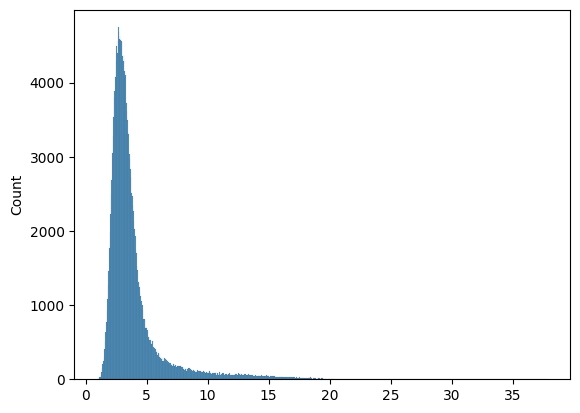

In [44]:
tmp = residstd.flatten()
sns.histplot(tmp[tmp>0])

In [42]:
# plotting.view_img(
#     nb.Nifti1Image(residstd, affine=mask.affine, header=mask.header),
#     vmin=0, vmax=10,
#     symmetric_cmap=False, cmap=cm.Reds
# )

---